In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter

import sklearn.metrics as metrics
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline  


import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

In [17]:
df_features = pd.read_pickle("data_set/df_features_estandarizado.pickle")
df_features.head()

agrupacion_feature       media                                          \
feature                  delta     theta     alpha      beta     gamma   
tipo indice_paciente                                                     
P    0                0.500218 -0.240771 -0.688548 -0.459638 -0.406289   
     1                0.970334  0.601456 -0.762397 -0.775901 -0.369460   
     2                2.070471  0.795315 -0.646674 -0.835162 -0.482753   
     3                0.734391  1.359020 -0.410337 -0.592436 -0.501728   
     4                1.537761  0.742978 -0.572930 -0.462701 -0.280550   

agrupacion_feature                                                          \
feature              delta_norm theta_norm alpha_norm beta_norm gamma_norm   
tipo indice_paciente                                                         
P    0                 0.837666  -0.071074  -0.666111 -0.396677  -0.322384   
     1                 1.079809   0.547332  -0.920190 -1.062210  -0.398412   
     2                 1.370391  -0.193502  -0.852261 -1.294888  -0.517556   
     3                 0.578035   1.356012  -0.573282 -0.948825  -0.521571   
     4                 1.062737   0.100820  -0.785426 -0.944991  -0.380050   

agrupacion_feature      ...          std                                 \
feature                 ...        alpha      beta     gamma delta_norm   
tipo indice_paciente    ...                                               
P    0                  ...    -0.603870  0.195745 -0.339861   0.542809   
     1                  ...    -0.684283 -0.636885 -0.386052   0.706450   
     2                  ...    -0.661683 -0.924978 -0.559998  -0.959542   
     3                  ...    -0.343123 -0.445636 -0.519770   1.467841   
     4                  ...    -0.621974 -0.682284 -0.354744   0.278225   

agrupacion_feature                                                         \
feature              theta_norm alpha_norm beta_norm gamma_norm     intra   
tipo indice_paciente                                                        
P    0                 0.114840  -0.453845  0.337590  -0.055859  1.574465   
     1                 1.161500  -1.161972 -1.153092  -0.429586 -0.158501   
     2                -0.148300  -0.983480 -1.932346  -0.810451  1.055501   
     3                 1.439780  -0.350221 -0.981742  -0.788827  0.124952   
     4                 0.464447  -0.914285 -1.192041  -0.408850 -0.482241   

agrupacion_feature              
feature                  inter  
tipo indice_paciente            
P    0                0.652673  
     1                1.019270  
     2                1.554689  
     3                1.024255  
     4                1.149974  

[5 rows x 24 columns]

<h3>Aclaración previa</h3>
<p>Se definió como "positivo" a aquellos individuos con capacidad cognitiva reducida. Como se verá adelante, esta decisión influencia sobre la efectividad de algunos de los métodos con los cuales se experimenta.

In [3]:
# Agrego 1 y 0 para indicar si son o no casos de capacidad cognitiva reducida
df_features["valor_real"] = 0
df_features.loc["P","valor_real"] = 1

In [4]:
c_bandas = ["alpha", "beta", "delta", "gamma", "theta"]
c_bandas_norm = [b+"_norm" for b in c_bandas]
c_entropia = ["inter", "intra"]

c_bandas = [(a,b) for  a in ["media", "std"]for b in c_bandas]
c_bandas_norm = [(a,b) for  a in ["media", "std"]for b in c_bandas_norm]
c_entropia = [(a,b) for  a in ["media", "std"]for b in c_entropia]

<h1>Análisis univariado</h1>
<p>En esta primera sección se busca analizar la capacidad como clasificador de cada <i>feature</i> por separado. Para ello, dada una <i>feature</i> particular, se plantean dos métodos:
<ol>
<li>Utilizar únicamente un umbral tal que serán clasificados como casos positivos aquellas instancias cuyos valores para dicha <i>feature</i> sean mayores al umbral en cuestión.</li>
<li>Entrenar un modelo de regresión logística para cada <i>feature</i>, prediciendo luego la probabilidad de que cada instancia sea o no positiva. Hecho esto se utilizará nuevamente un umbral para definir cuales instancias son positivas.</li>
</ol>

In [5]:
def threshold_ROC(expected, predicted, feature_name, ax=None, plot_ROC=True, **plot_args):
    fpr, tpr, _ = metrics.roc_curve(expected, predicted)
    roc_auc = metrics.auc(fpr, tpr)

    if plot_ROC:
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.plot(fpr, tpr, lw=4, **plot_args)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        feature_name = feature_name.replace("estándar ", "estándar\n")
        ax.set_title('{name}'.format(name=feature_name, AUC=roc_auc))
    
    return roc_auc

def name_of_feature(c):
    return " ".join([c[0], *(c[1].split("_"))]).capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar")

# COMO METO EL POLIMORFISMO!!1!UNO

def nombre_bonito(s):
    return s.capitalize().replace("norm", "normalizada").replace("Std", "Desviación estándar").replace("_", " ")

In [6]:
def analisis_univariado(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        feature_name = name_of_feature(c)
        plot_args = {
            "color": 'darkorange',
            "ls": "-."
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            df_[c],
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )

        df_metr.loc[c,"umbral_auc"] = auc
    
    return axes


In [7]:
def analisis_regresion_logistica(df_, df_metr, axes):
    for c in (c_bandas + c_bandas_norm + c_entropia):
        clf = linear_model.LogisticRegression()
        X = df_[c].values.reshape(df_[c].size,1)
        Y = df_["valor_real"]
        scores = model_selection.cross_val_score(clf, X, Y)
        df_metr.loc[c, "regLog_score"] = sum(scores) / len(scores)
        
        clf.fit(X, Y)
        predicted = clf.predict(X)
        
        plot_args = {
            "color": "red",
            "ls": ":"
        }
        auc = threshold_ROC(
            df_["valor_real"].values,
            predicted,
            feature_name=name_of_feature(c),
            ax=axes[c],
            **plot_args
        )
        
        df_metr.loc[c, "regLog_auc"] = auc
        

<h2>Curvas ROC</h2>
<p> Para comparar inicialmente la efectividad de ambos métodos se crean las curvas ROC correspondientes a cada <i>feature</i>.

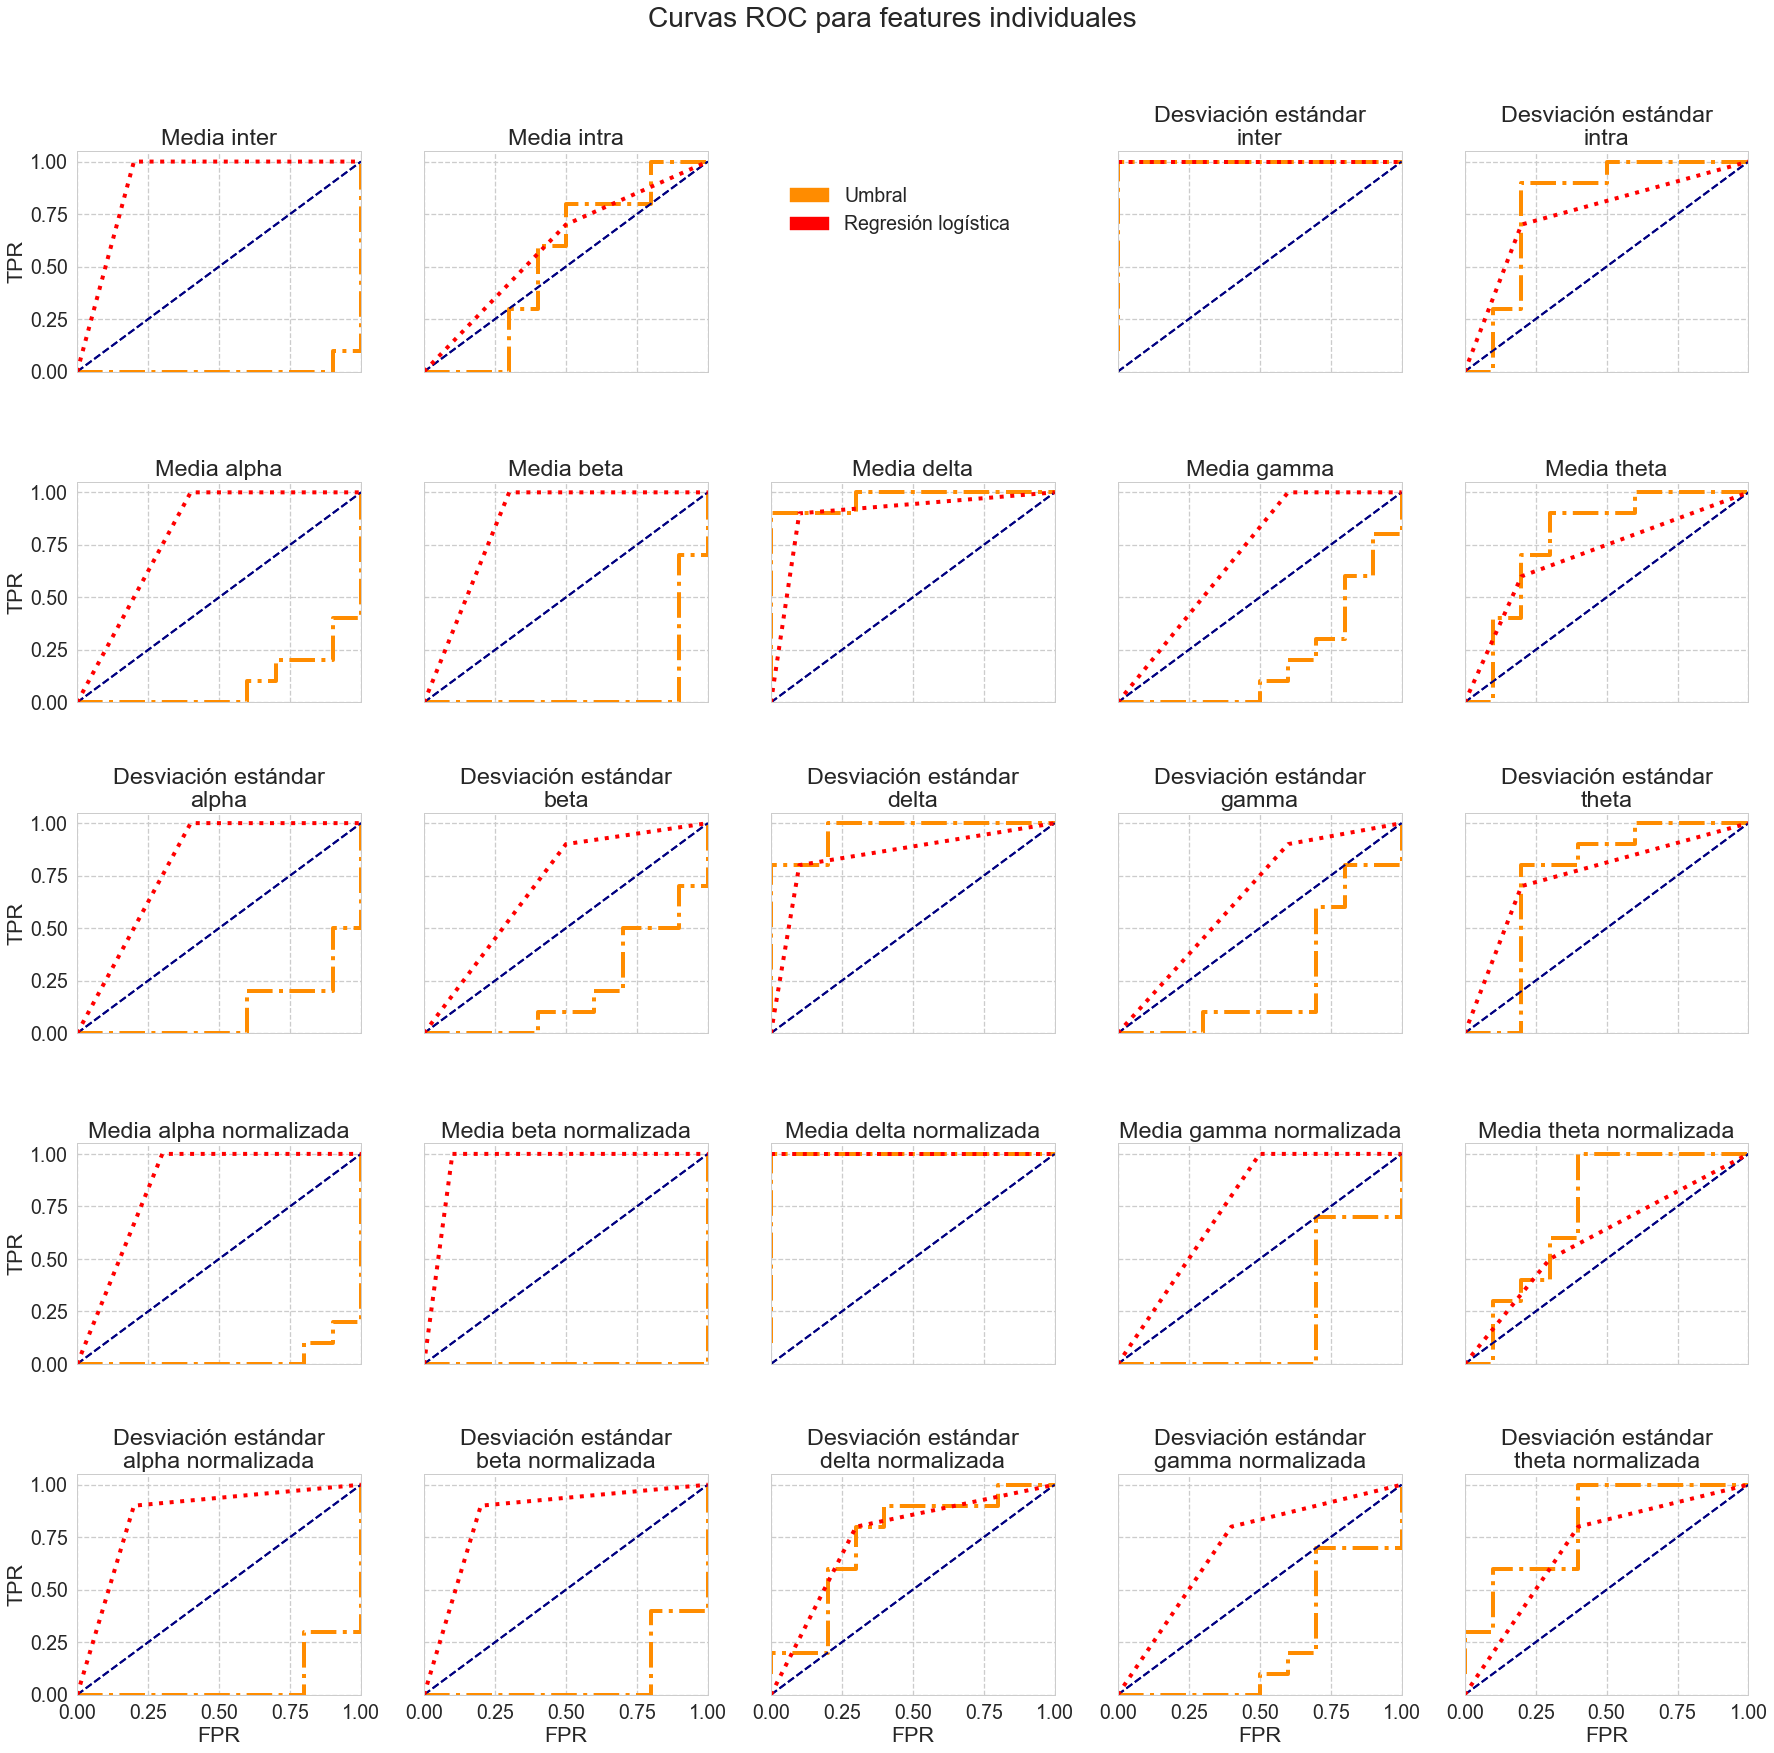

In [8]:
plt.close()

axes = dict()
fig = plt.figure(figsize=(25,25))
for son_bandas, l in [(True, c_bandas+c_bandas_norm), (False, c_entropia)]:
    for j, c in enumerate(l):
        if son_bandas:
            i = (0 if c[0] == "media" else 1) + (2 if j >=10 else 0) + 1
            j = j % 5
        else:
            i = 0
            j = j if j < 2 else (j+1)

        ax = plt.subplot2grid((5,5), (i,j))
        axes[c] = ax
        if i == 4:
            ax.set_xlabel('FPR')
        else:
            ax.xaxis.set_major_formatter(NullFormatter())

        if j == 0:
            ax.set_ylabel('TPR')
        else:
            ax.yaxis.set_major_formatter(NullFormatter())

df_metricas = pd.DataFrame(
    index=pd.MultiIndex.from_arrays(list(zip(*sorted(c_bandas + c_bandas_norm + c_entropia)))))
analisis_univariado(df_features, df_metricas, axes)
analisis_regresion_logistica(df_features, df_metricas, axes)

p_reg_log = mpatches.Patch(color='red')
p_umbral = mpatches.Patch(color='darkorange')
fig.legend(
    labels=['Umbral', 'Regresión logística'],
    handles=[p_umbral, p_reg_log],
    loc="upper center",
    bbox_to_anchor=(0.5, 0.88)
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
plt.subplots_adjust(top=0.9)
plt.suptitle("Curvas ROC para features individuales")

plt.show()

<h2>Valores de AUC</h2>
<p> Para complementar las curvas ROC, se muestra a continuación el valor de AUC para cada una de ellas.

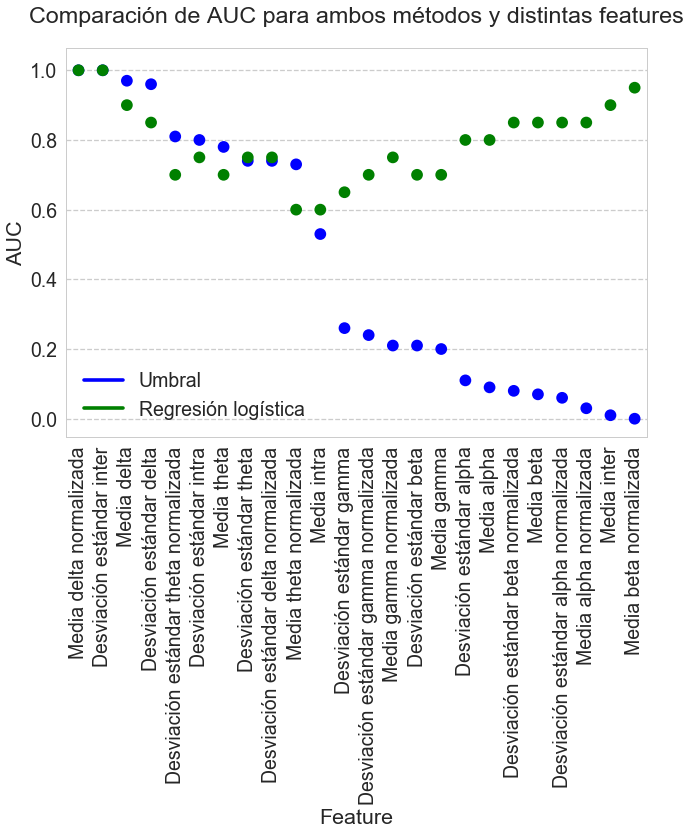

In [9]:
c_feature = "Feature"
df_auc = df_metricas.reset_index()
df_auc[c_feature] =  (df_auc["level_0"] + " " + df_auc["level_1"]).apply(nombre_bonito)

c_umbral = "Umbral"
c_reg_log = "Regresión logística"
c_feature = "Feature"
df_auc.rename(columns={"umbral_auc": c_umbral, "regLog_auc": c_reg_log}, inplace=True)
df_auc = df_auc[[c_feature, c_umbral, c_reg_log]].sort_values(c_umbral, ascending=False)

f, ax = plt.subplots(1, 1)
args = {
    "data": df_auc,
    "ax": ax,
    "x": c_feature,
    "join": False
}

plt.xticks(rotation=90)
sns.pointplot(y=c_umbral, color='blue', **args)
sns.pointplot(y=c_reg_log, color='green', **args)
ax.legend(handles=ax.lines[::len(df_auc)+1], labels=["Umbral","Regresión logística"])

plt.ylabel("AUC")
ttl = plt.title("Comparación de AUC para ambos métodos y distintas features")
ttl.set_position([.5, 1.05])

plt.show()
    

La primer observación a realizar es como el método obtiene resultados extremos: por un lado se obtienen altos valores de AUC para <b>Media Delta Normalizada</b> o <b>Desviación Estandar Inter</b>, mientras que con otros <i>features</i> el resultado es completamente distinto, como en la <b>Media Intra</b>.
Sin embargo ésto no se debe a que no sean separables los valores de ambos grupos: de hecho, en los casos donde el AUC es prácticamente cero, el problema es que la predicción que se está realizando es completamente inversa a lo que debería ser.

La causa es que el método simplemente utiliza un umbral particular, clasificando luego como negativos a aquellos que estén por debajo de él y como positivos a aquellos que estén por arriba.
Si para alguna <i>feature</i> los valores difieren entre ambas clases, pero con la particularidad de que las instancias negativas tienen mayores valores, entonces el método será inútil.
Una solución sencilla sería agregar como <i>features</i> al negativo de cada una ya existente y elegir para el método umbral a aquella de las dos que sea conveniente.
Si se realizara esta modificación el método umbral no tendría casos donde el AUC sea menor a 0.5.

Así como vemos nuestros resultados de comparación de AUC como con las curvas ROC, se puede notar que el modelo de regresión logística se ajusta bien a nuestros datos, siendo el candidato a elección entre ambos métodos.  

<h2>Validación cruzada para regresión logística</h2>
<p> Se muestra a continuación el resultado obtenido para los modelos individuales de regresión logística.


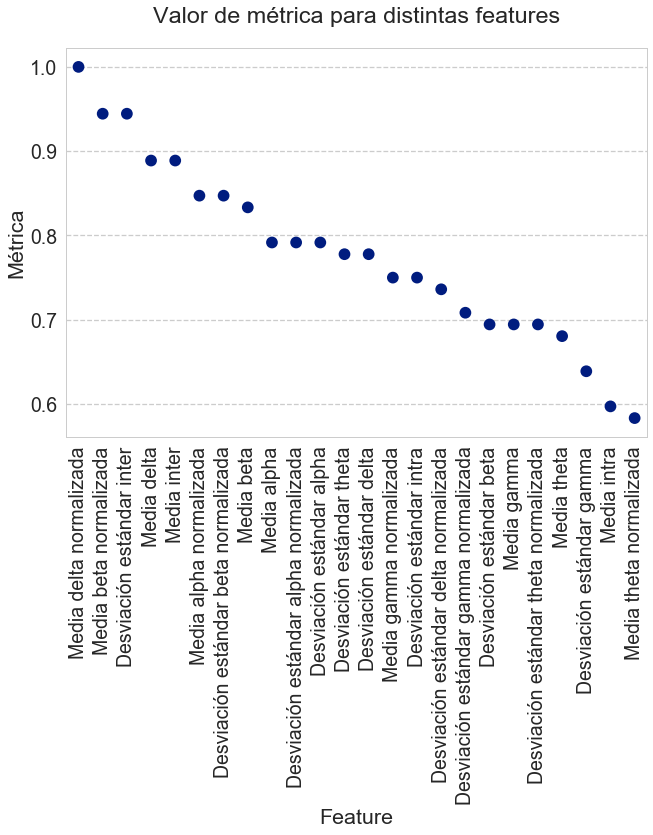

In [10]:
c_feature = "Feature"
df_reg_log = df_metricas.reset_index()
df_reg_log[c_feature] =  (df_reg_log["level_0"] + " " + df_reg_log["level_1"]).apply(nombre_bonito)
    
c_metrica = "Métrica"
df_reg_log.rename(columns={"regLog_score": c_metrica}, inplace=True)
df_reg_log = df_reg_log[[c_feature, c_metrica]].sort_values(c_metrica, ascending=False)

plt.xticks(rotation=90)
sns.pointplot(x=c_feature, y=c_metrica, data=df_reg_log, join=False)

plt.ylabel(c_metrica)
ttl = plt.title("Valor de {} para distintas features".format(c_metrica.lower()))
ttl.set_position([.5, 1.05])

plt.show()

Podemos ver como se podía esperar por el gráfico anterior que los mejores resultados se obtienen con los features <b>Media Delta Normalizada</b>, <b>Media Beta Normalizada</b> y <b>Desviación Estandar Inter</b>. En el caso de este primer feature, también nos condujo a buenos resultados utilizando umbrales, lo cual nos dice que aporta mucha información en una clasificación. Sería de interés comprobar estos resultados con más sets de prueba.

<h1>Análisis multivariado</h1>
<p> En esta sección se analizan los resultados obtenidos con clasificadores basados en el algoritmo de <i>Support Vector Machine</i> según dos variantes:
<ol>
    <li>Utilizar todos los <i>features</i> para entrenar el clasificador.</li>
    <li>Aplicar un <i>pipeline</i> basado en un <i>scaler</i>, <i>feature selection</i> y finalmente la clasificación utilizando SVM</li>
</ol>

In [11]:
X = df_features.drop(("valor_real", ""), axis=1)
Y = df_features["valor_real"]


In [12]:
def analisis_modelo(fitted_clf, X, Y, ax=ax, plot_ROC=True):
    classes_prob = fitted_clf.predict_proba(X)
    
    idx_class = np.where(fitted_clf.classes_ == 1)[0][0]
    predicted = classes_prob[:,idx_class]

    scores = model_selection.cross_val_score(fitted_clf, X, Y)
    final_score = sum(scores) / len(scores)

    plot_args = {
        "color": "black",
        "ls": ":"
    }

    auc = threshold_ROC(Y.values, predicted, "SVM", ax=ax, plot_ROC=plot_ROC, **plot_args)
    return auc, final_score

Para comparar los resultados de ambos clasificadores se gráfican las correspondientes curvas ROC y se calcula el score obtenido.

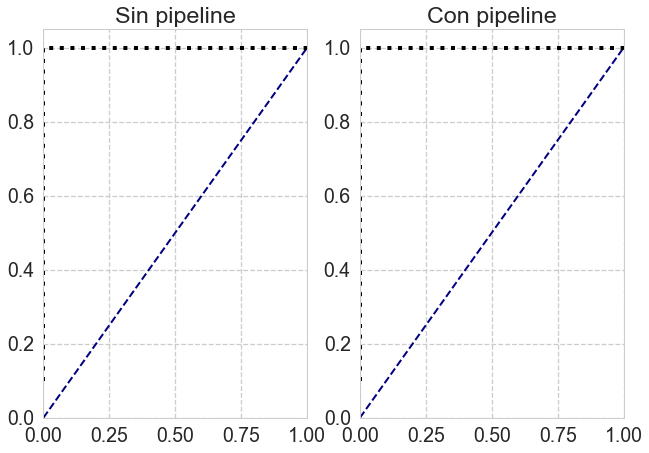

Resultados obtenidos para SVM sin pipeline
	AUC: 1.00
	Score: 0.94
Resultados obtenidos para SVM con pipeline
	AUC: 1.00
	Score: 1.00


In [15]:
f, axes = plt.subplots(1,2)

# SVM sin pipeline
clf_sin_pipeline = SVC(probability=True)
clf_sin_pipeline.fit(X,Y)

auc_sp, score_sp = analisis_modelo(clf_sin_pipeline, X, Y, ax=axes[0])

# SVM con pipeline
steps = [
    ("preprocesamiento", MinMaxScaler()),
    ("selector_features", SelectKBest(k=2)),
    ("svm", SVC(probability=True))
]

clf_con_pipeline = Pipeline(steps)
clf_con_pipeline.fit(X,Y)

auc_cp, score_cp = analisis_modelo(clf_con_pipeline, X, Y, ax=axes[1])

axes[0].set_title("Sin pipeline")
axes[1].set_title("Con pipeline")
plt.show()

for m, a, s in [("SVM sin pipeline", auc_sp, score_sp), ("SVM con pipeline", auc_cp, score_cp)]:
    print("Resultados obtenidos para", m)
    print("\tAUC:", "{:0.2f}".format(a))
    print("\tScore:", "{:0.2f}".format(s))


Se puede ver que aunque el AUC haya arrajodo el mismo valor, el score final obtenido es mejor utilizando pipeline. 

Para este pipeline se utilizó sólo el 10% de los features (2 de 20 en este caso), de modo que puede ser de interés observar los resultados obtenidos utilizanod más. El siguiente gráfico muestra cómo afecta la cantidad de features utlizadas en el score del modelo.

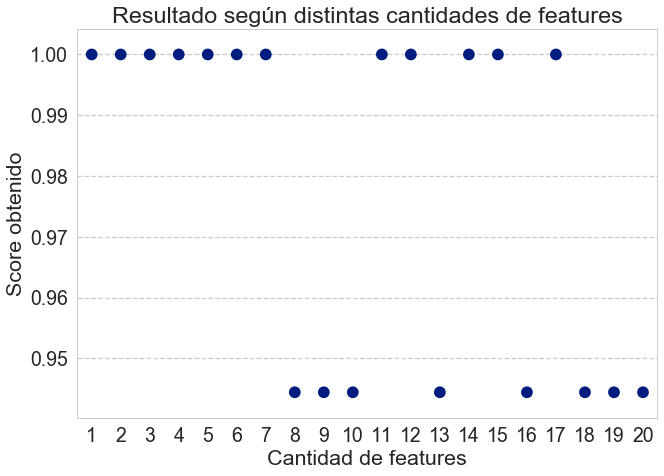

In [14]:
cantidades = list(range(1,21))
df_scores = pd.DataFrame(data={"Score":np.zeros(20)}, index=cantidades)

for mi_k in cantidades:
    # SVM con pipeline
    steps = [
        ("preprocesamiento", MinMaxScaler()),
        ("selector_features", SelectKBest(k=mi_k)),
        ("svm", SVC(probability=True))
    ]

    clf = Pipeline(steps)
    clf.fit(X,Y)

    _, score = analisis_modelo(clf, X, Y, plot_ROC=False)
    df_scores.loc[mi_k] = score
    
df_scores = df_scores.reset_index().rename(columns={"index": "Cantidad de features"}) 

sns.pointplot(data=df_scores, x="Cantidad de features", y="Score", join=False)
plt.ylabel("Score obtenido")
plt.title("Resultado según distintas cantidades de features")
plt.show()

<h3>Conclusiones</h3>
<blockquote>
    <p>Pueden encontrarse varios modelos que obtengan buenos datos en base a nuestro set de datos, tanto univariado como multivariado. Teniendo en cuenta:
    <ul>
        <li>que tenemos pocas muestras.</li>
        <li>los resultados obtenidos.</li>
        <li>la recomendaciónde la cátedra N > 2 <sup>d</sup> de la cátedra con <i>d</i> la cantidad de features y <i>N</i>la cantidad de muestras necesarias para entrenar nuestro modelo.</li>
    </ul>
    <p>se escoge el último clasficador sobre los demás (basado en SVM con pipeline utilizando el 10% de los features).</p>
</blockquote>